
# Anaomaly Detection  - Titel balal



# Modeling 

- Further problems -> Thresholding?
- Evalution of normel behaviour

# TODO:
Different Algorithms, Grid search, remeber train data is supposed to have no anomalies, test data has and we know it already 
Consider validierungsset ! Also: train with test data and then predict train
Calculate the amount of anomlous data percentage
LSTM
Anomaly scoring plotten und verhalten bewerten
notes Arbeitslaptop
Bewertung über knowledge of exploits und der Nummer die der Isolation Forest erkennt ? Confusion Matrix!

TODO: CODE aufräumen + Notebooks, Evaluation Methoden Integrieren (Brier Score), Mehrre Models + Datensets, LOCAL OUTLIER DETECTION


### Idea
Feed with dostributions to detect anomal behaviour, What is normal behaviour - from a statistical ppoint of view 
adapating the threshold, if a certain threshold is reached the data doesn't follow normal distribution








# Explorative Data Analysis
### Before Preprocessing


## Meta Information
- Structured data - computer resources 
Similiar to docker stats command: https://docker-py.readthedocs.io/en/stable/containers.html#docker.models.containers.Container.stats, https://docs.docker.com/config/containers/runmetrics/
    time series: datetime format 
    cpu usage:
    memory usage: 
    network received: rx (Received) bytes 
    network send: tx (Transmit) bytes 
    storage read:
    storage written:
- Unsupervised Problem - Unsupervised means no labels and a model is trained on the complete data and assumes that the majority of the instances are normal.
- was sind das für Größen, Skalierbarkeit ? verschieddene größen 
- fruterh ideas : time series data lags, autocorrelation 


Does it make sense to look at each container seperatly?

 eth0 - Network Interface 
 REMEBER: Anzahl an Einträgen von Docker Container ist recording lenth -> hence 45 sec.

In [1]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.stats import shapiro 

from helpers import *
from predict import A_Model
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, auc

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

In [2]:
# Load Data
train = pd.read_pickle("/Users/janavihs/projects/anomaly-detection-software/data/interim/raw/train.pkl")
test = pd.read_pickle("/Users/janavihs/projects/anomaly-detection-software/data/interim/raw/test.pkl")
validation = pd.read_pickle("/Users/janavihs/projects/anomaly-detection-software/data/interim/raw/validation.pkl")

In [3]:
train.head()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written,exploit,timestamp_container_ready,timestamp_trick_admin,timestamp_execute_reverse_shell,timestamp_warmup_end,container_name,dates,times
timestamp,,,,,,,,,,,,,,
2021-09-09 23:21:47.309,0.111557,17649664,7532,18490,0,0,False,2021-09-09 23:21:43.732901,0,0,2021-09-09 23:21:46.736133,abundant_buck_7911,2021-09-09,23:21:47.309000
2021-09-09 23:21:48.319,0.123430,19746816,5158,11520,0,0,False,2021-09-09 23:21:43.732901,0,0,2021-09-09 23:21:46.736133,abundant_buck_7911,2021-09-09,23:21:48.319000
2021-09-09 23:21:49.336,0.121031,21782528,2818,11246,0,0,False,2021-09-09 23:21:43.732901,0,0,2021-09-09 23:21:46.736133,abundant_buck_7911,2021-09-09,23:21:49.336000
2021-09-09 23:21:50.345,0.145855,25518080,4402,13775,0,0,False,2021-09-09 23:21:43.732901,0,0,2021-09-09 23:21:46.736133,abundant_buck_7911,2021-09-09,23:21:50.345000
2021-09-09 23:21:51.364,0.343448,32534528,9146,36294,0,0,False,2021-09-09 23:21:43.732901,0,0,2021-09-09 23:21:46.736133,abundant_buck_7911,2021-09-09,23:21:51.364000


In [4]:
test.head()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written,exploit,timestamp_container_ready,timestamp_trick_admin,timestamp_execute_reverse_shell,timestamp_warmup_end,container_name,dates,times
timestamp,,,,,,,,,,,,,,
2021-12-21 16:29:19.790,0.000556,13762560,872,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:19.790000
2021-12-21 16:29:20.795,0.000329,13762560,422,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:20.795000
2021-12-21 16:29:21.802,0.121941,16089088,4671,13851,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:21.802000
2021-12-21 16:29:22.808,0.021975,17104896,221,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:22.808000
2021-12-21 16:29:23.815,0.059089,19099648,0,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:23.815000


In [5]:
calculate_anomalous_rate(validation)

0.0

In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9564 entries, 2021-09-09 23:21:47.309000 to 2021-09-15 12:32:22.769000
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   cpu_usage                        9564 non-null   float64       
 1   memory_usage                     9564 non-null   int64         
 2   network_received                 9564 non-null   int64         
 3   network_send                     9564 non-null   int64         
 4   storage_read                     9564 non-null   int64         
 5   storage_written                  9564 non-null   int64         
 6   exploit                          9564 non-null   object        
 7   timestamp_container_ready        9564 non-null   datetime64[ns]
 8   timestamp_trick_admin            9564 non-null   object        
 9   timestamp_execute_reverse_shell  9564 non-null   object        
 10  timestamp_

In [8]:
# Check for missing values
print("#######################")
print("Train Data:")
print("#######################")
print(train.isnull().sum())
print("#######################")
print("Test Data")
print("#######################")
print(test.isnull().sum())

#######################
Train Data:
#######################
cpu_usage                          0
memory_usage                       0
network_received                   0
network_send                       0
storage_read                       0
storage_written                    0
exploit                            0
timestamp_container_ready          0
timestamp_trick_admin              0
timestamp_execute_reverse_shell    0
timestamp_warmup_end               0
container_name                     0
dates                              0
times                              0
dtype: int64
#######################
Test Data
#######################
cpu_usage                          0
memory_usage                       0
network_received                   0
network_send                       0
storage_read                       0
storage_written                    0
exploit                            0
timestamp_container_ready          0
timestamp_trick_admin              0
timestamp_execute_

In [9]:
print("#######################")
print("Train Data:")
print("#######################")
print(train.shape)
print("#######################")
print("Test Data")
print("#######################")
print(test.shape)

#######################
Train Data:
#######################
(9564, 14)
#######################
Test Data
#######################
(39927, 14)


In [10]:
# Check for the amount of zeros 
print("#######################")
print("Train Data:")
print("#######################")
columns = train.columns.tolist()
print((train[columns]== 0).sum())
print("#######################")
print("Test Data")
print("#######################")
columns_test = test.columns.tolist()
print((test[columns]== 0).sum())

#######################
Train Data:
#######################
cpu_usage                             0
memory_usage                          0
network_received                    531
network_send                        584
storage_read                       9556
storage_written                    9332
exploit                            9564
timestamp_container_ready             0
timestamp_trick_admin              9564
timestamp_execute_reverse_shell    9564
timestamp_warmup_end                  0
container_name                        0
dates                                 0
times                                 0
dtype: int64
#######################
Test Data
#######################
cpu_usage                              0
memory_usage                           0
network_received                    2387
network_send                        3017
storage_read                       39774
storage_written                    38818
exploit                            34621
timestamp_container_re

In [11]:
train.describe() # Only positive values

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written
count,9564.000000,9.564000e+03,9564.000000,9564.000000,9564.000000,9564.000000
mean,0.141092,3.586510e+07,4084.739753,16489.362087,67.238812,154.606441
std,0.107538,8.686077e+06,3197.226831,29075.417379,4265.001791,1107.688249
min,0.000277,1.531904e+07,0.000000,0.000000,0.000000,0.000000
25%,0.076871,3.189555e+07,2091.000000,6932.000000,0.000000,0.000000
50%,0.123746,3.720806e+07,3485.000000,11631.000000,0.000000,0.000000
75%,0.181755,4.089446e+07,5227.000000,18469.000000,0.000000,0.000000
max,1.146535,6.668288e+07,28425.000000,354543.000000,356352.000000,20480.000000


In [12]:
test.describe()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written
count,39927.000000,3.992700e+04,39927.000000,39927.000000,3.992700e+04,3.992700e+04
mean,0.141173,3.568852e+07,4121.127733,16244.512260,3.506431e+02,2.255893e+02
std,0.111868,8.876811e+06,3479.540021,29279.070981,1.623316e+04,1.177772e+04
min,0.000129,1.361920e+07,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.071625,3.198566e+07,2090.000000,5374.500000,0.000000e+00,0.000000e+00
50%,0.125114,3.719578e+07,3485.000000,11593.000000,0.000000e+00,0.000000e+00
75%,0.184521,4.099277e+07,5395.000000,18557.500000,0.000000e+00,0.000000e+00
max,2.314982,7.683277e+07,35819.000000,614079.000000,1.503232e+06,2.342912e+06


In [13]:
# check variances 
train.var()

/var/folders/w0/j_glm66x74z4bc3n2z6xd92r0000gn/T/ipykernel_25540/1790325689.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.var()


cpu_usage                          1.156453e-02
memory_usage                       7.544793e+13
network_received                   1.022226e+07
network_send                       8.453799e+08
storage_read                       1.819024e+07
storage_written                    1.226973e+06
exploit                            0.000000e+00
timestamp_trick_admin              0.000000e+00
timestamp_execute_reverse_shell    0.000000e+00
dtype: float64

## Distribution for each Feature

### CPU-Usage

CPU-Usage and Memory Consumption are propably the best indicators

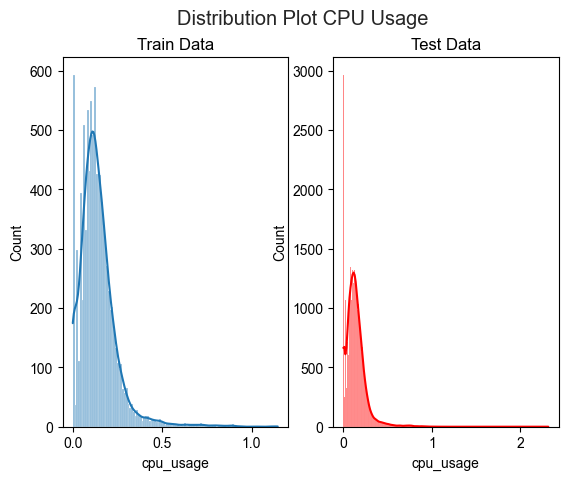

In [14]:
fig, axes = plt.subplots(1,2)
sns.set()
fig.suptitle('Distribution Plot CPU Usage')
axes[0].set_title('Train Data')
axes[1].set_title('Test Data')
sns.histplot(train.cpu_usage, kde=True, ax=axes[0])# left skewed
sns.histplot(test.cpu_usage, kde=True, ax=axes[1], color='red') # left skewed
plt.show()

In [15]:
print("#############################")
print("Train Data:")
print("#############################")
print("Skewness: %f" % train['cpu_usage'].skew())
print("Kurtosis: %f" % train['cpu_usage'].kurt())
print("#############################")
print("Test Data:")
print("#############################")
print("Skewness: %f" % test['cpu_usage'].skew())
print("Kurtosis: %f" % test['cpu_usage'].kurt())

#############################
Train Data:
#############################
Skewness: 2.476019
Kurtosis: 11.709240
#############################
Test Data:
#############################
Skewness: 2.678905
Kurtosis: 16.378067


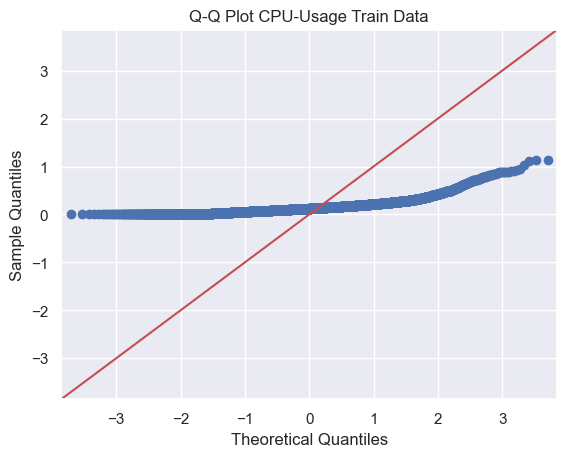

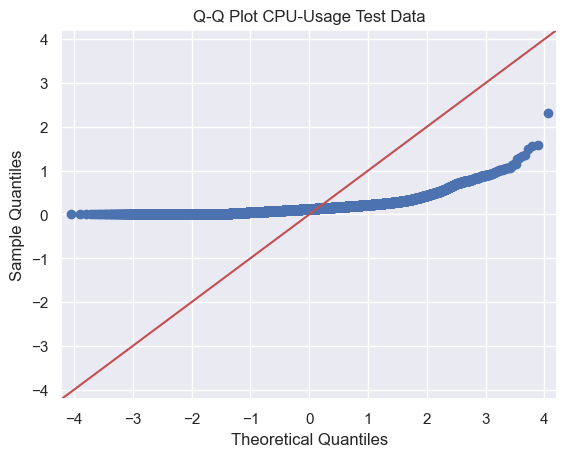

In [16]:
# Q-Q Plot 
fig = sm.qqplot(train.cpu_usage, line='45') # cpu usage does not follow normal behaviour
plt.title("Q-Q Plot CPU-Usage Train Data")
plt.show()
# Q-Q Plot 
fig = sm.qqplot(test.cpu_usage, line='45') # cpu usage does follow normal behaviour
plt.title("Q-Q Plot CPU-Usage Test Data")
plt.show()

### Memory Consumption

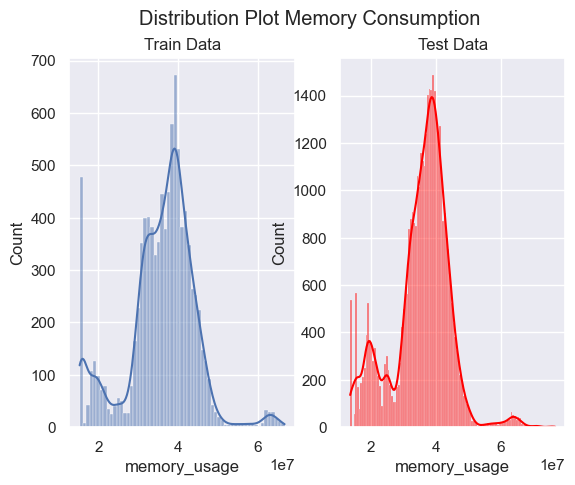

In [17]:
fig, axes = plt.subplots(1,2)
sns.set()
fig.suptitle('Distribution Plot Memory Consumption')
axes[0].set_title('Train Data')
axes[1].set_title('Test Data')
sns.histplot(train['memory_usage'], kde=True, ax=axes[0])# left skewed
sns.histplot(test['memory_usage'], kde=True, ax=axes[1], color='red') # left skewed
plt.show()

## Network send and Network received

center close to/ around zero with huge outliers --> How to handle? Try different Transformations

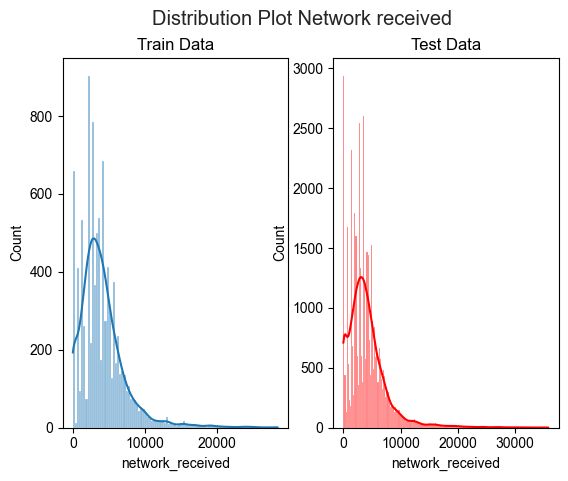

In [5]:
fig, axes = plt.subplots(1,2)
sns.set()
fig.suptitle('Distribution Plot Network received')
axes[0].set_title('Train Data')
axes[1].set_title('Test Data')
sns.histplot(train['network_received'], kde=True, ax=axes[0])# left skewed
sns.histplot(test['network_received'], kde=True, ax=axes[1], color='red') # left skewed
plt.show()

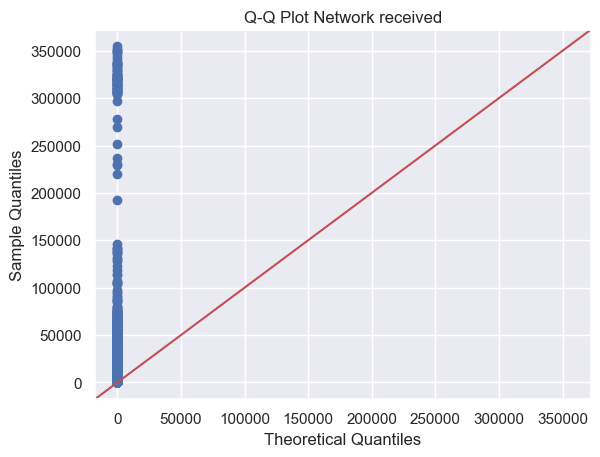

In [24]:
# Q-Q Plot 
fig = sm.qqplot(train.network_send, line='45') # Cpu_Usage follows normal behaviour
plt.title("Q-Q Plot Network received")
plt.show()

## Storage read and Storage written

Same behaviour as Network send and Network received, center around zero but huge outliers


Text(0.5, 1.0, 'Correlation between Features in Test Data')

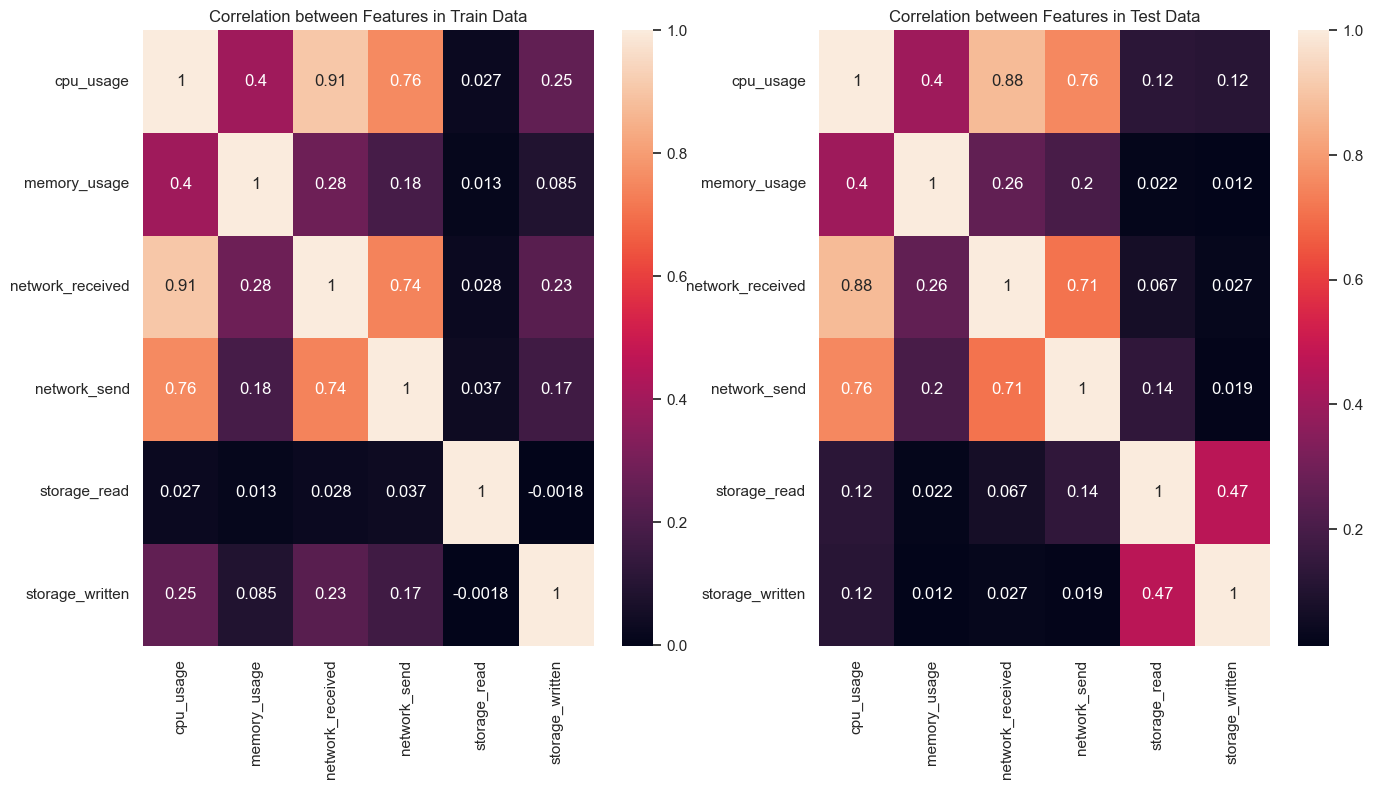

In [17]:
# Correlation of all features -> Scaling after does not make a difference
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.heatmap(train.corr(), annot=True)
plt.title("Correlation between Features in Train Data")
plt.subplot(1, 2, 2)
sns.heatmap(test.corr(), annot=True)
plt.title("Correlation between Features in Test Data")

## Time Series Data 

In [14]:
# only observations where the attack is happening 
attack = test[test['exploit']==True]
attack.shape

(5306, 14)

In [15]:
attack.head(5)

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written,exploit,timestamp_container_ready,timestamp_trick_admin,timestamp_execute_reverse_shell,timestamp_warmup_end,container_name,dates,times
timestamp,,,,,,,,,,,,,,
2021-12-21 16:29:19.790,0.000556,13762560,872,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:19.790000
2021-12-21 16:29:20.795,0.000329,13762560,422,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:20.795000
2021-12-21 16:29:21.802,0.121941,16089088,4671,13851,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:21.802000
2021-12-21 16:29:22.808,0.021975,17104896,221,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:22.808000
2021-12-21 16:29:23.815,0.059089,19099648,0,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:23.815000


In [34]:
attack.describe()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written
count,5306.000000,5.306000e+03,5306.000000,5306.000000,5306.000000,5306.00000
mean,0.083013,2.760204e+07,2747.686204,7649.054655,1652.758387,145.12778
std,0.107067,1.021272e+07,4507.497781,19925.474157,32723.143712,959.87894
min,0.000129,1.361920e+07,0.000000,0.000000,0.000000,0.00000
25%,0.000435,1.930445e+07,0.000000,0.000000,0.000000,0.00000
50%,0.052395,2.498560e+07,1058.000000,879.000000,0.000000,0.00000
75%,0.125732,3.663667e+07,3732.000000,9543.750000,0.000000,0.00000
max,0.978665,6.451200e+07,33293.000000,387191.000000,962560.000000,20480.00000


In [35]:
# compare with the oberservations where no exploit is happening 
no_attack = test[test['exploit']==False]
no_attack.shape

(34621, 14)

In [36]:
no_attack.describe()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written
count,34621.000000,3.462100e+04,34621.000000,34621.000000,3.462100e+04,3.462100e+04
mean,0.150087,3.692785e+07,4331.620808,17561.848502,1.510815e+02,2.379208e+02
std,0.109899,7.958278e+06,3242.841269,30244.912849,1.181179e+04,1.264248e+04
min,0.000277,1.503232e+07,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.084617,3.323904e+07,2184.000000,7035.000000,0.000000e+00,0.000000e+00
50%,0.132050,3.777331e+07,3666.000000,11789.000000,0.000000e+00,0.000000e+00
75%,0.189306,4.131635e+07,5576.000000,18913.000000,0.000000e+00,0.000000e+00
max,2.314982,7.683277e+07,35819.000000,614079.000000,1.503232e+06,2.342912e+06


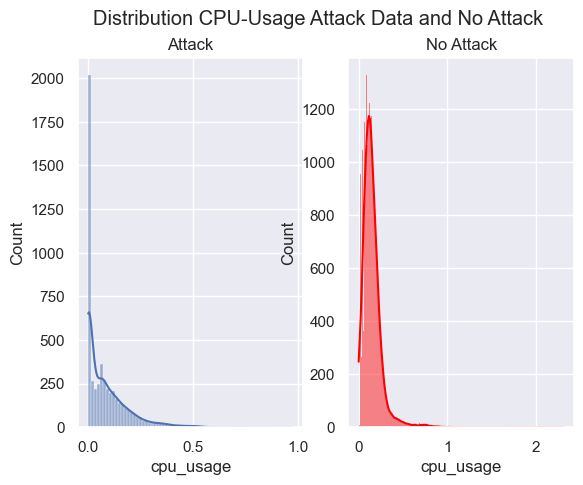

In [37]:
fig, axes = plt.subplots(1,2)
sns.set()
fig.suptitle('Distribution CPU-Usage Attack Data and No Attack')
axes[0].set_title('Attack')
axes[1].set_title('No Attack')
sns.histplot(attack['cpu_usage'], kde=True, ax=axes[0])# left skewed
sns.histplot(no_attack['cpu_usage'], kde=True, ax=axes[1], color='red') # left skewed
plt.show()

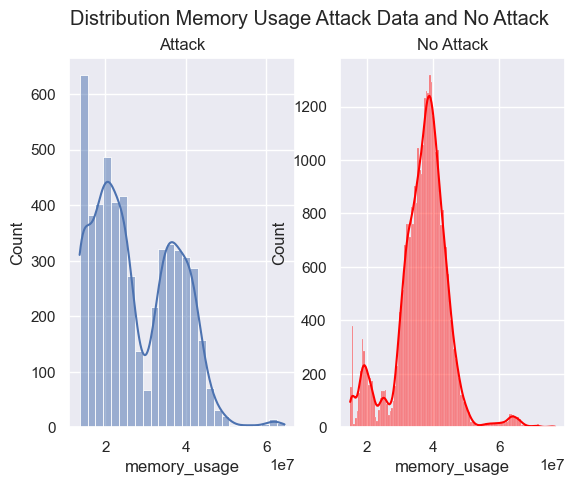

In [38]:
fig, axes = plt.subplots(1,2)
sns.set()
fig.suptitle('Distribution Memory Usage Attack Data and No Attack')
axes[0].set_title('Attack')
axes[1].set_title('No Attack')
sns.histplot(attack['memory_usage'], kde=True, ax=axes[0])# left skewed
sns.histplot(no_attack['memory_usage'], kde=True, ax=axes[1], color='red') # left skewed
plt.show()

In [39]:
test.head()

,cpu_usage,memory_usage,network_received,network_send,storage_read,storage_written,exploit,timestamp_container_ready,timestamp_trick_admin,timestamp_execute_reverse_shell,timestamp_warmup_end,container_name,dates,times
timestamp,,,,,,,,,,,,,,
2021-12-21 16:29:19.790,0.000556,13762560,872,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:19.790000
2021-12-21 16:29:20.795,0.000329,13762560,422,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:20.795000
2021-12-21 16:29:21.802,0.121941,16089088,4671,13851,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:21.802000
2021-12-21 16:29:22.808,0.021975,17104896,221,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:22.808000
2021-12-21 16:29:23.815,0.059089,19099648,0,0,0,0,True,2021-12-21 16:29:16.769860,2021-12-21 16:29:56.661277,2021-12-21 16:29:57.220510,2021-12-21 16:29:19.773270,abundant_knuth_3979,2021-12-21,16:29:23.815000


In [40]:
test['timestamp_between_attacks'] = test['timestamp_execute_reverse_shell']-test['timestamp_trick_admin']
#test['timestamp_execute_reverse_shell']+test['timestamp_trick_admin']

In [41]:
train = process.calc_time_delta(train)
test = process.calc_time_delta(test)

In [42]:
cn_dfs_train =process. split_by_container(train)
cn_dfs_test = process.split_by_container(test)

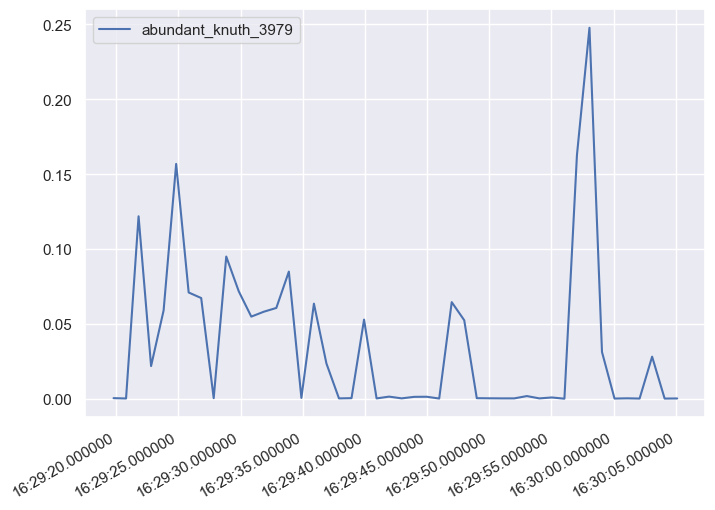

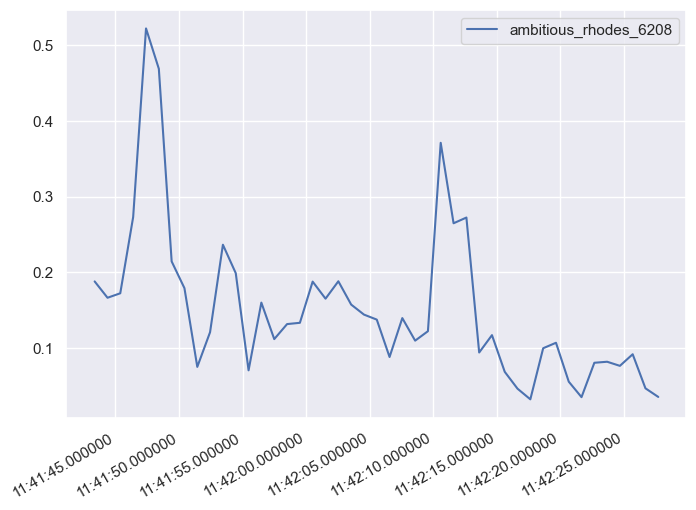

In [43]:
# Nochmal überarbeiten !
fig, ax = plt.subplots(figsize=(8,6))
xfmt = mdates.DateFormatter("%H:%M:%S.%f")
# automatically rotates the tick labels
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
ax.plot(cn_dfs_test[0]['tvalue'], cn_dfs_test[0]['cpu_usage'])
ax.legend(cn_dfs_test[0]['container_name'])
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
xfmt = mdates.DateFormatter("%H:%M:%S.%f")
# automatically rotates the tick labels
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()
ax.plot(cn_dfs_test[2]['tvalue'], cn_dfs_test[2]['cpu_usage'])
ax.legend(cn_dfs_test[2]['container_name'])
plt.show()

# PACF and ACF

In [51]:
to_model_columns= train.columns[0:6]
to_model_columns

Index(['cpu_usage', 'memory_usage', 'network_received', 'network_send',
       'storage_read', 'storage_written'],
      dtype='object')

In [58]:
shapiro(train['cpu_usage'].head(100))

ShapiroResult(statistic=0.8539355993270874, pvalue=1.6620175458115227e-08)

# Model 

In [4]:
# Split and encode Data for modelling and evaluation
validation = encode(validation)
test = encode(test)
train = encode(train)
y_true_train = create_y_values(train)
y_true_test = create_y_values(test)
y_true_validation = create_y_values(validation)
X_train = select_columns_for_modelling(train)
X_test = select_columns_for_modelling(test)
X_validation = select_columns_for_modelling(validation)

In [5]:
model = A_Model(model_type='IsolationForest')
model.load_model()

In [ ]:
ca = PCA(n_components=3)  # Reduce to k=3 dimensions
#scaler = StandardScaler()
#normalize the metrics
X = train[to_model_columns]
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [ ]:
pca = PCA(2)
pca.fit(train[to_model_columns])
res=pd.DataFrame(pca.transform(train[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest Visualization for Train Data")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

# Evaluation 

### Mass Vlume Curve 
### F1 Score

### Cnfusion Matrix

In [ ]:
algorithms = [IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)]
name = ['IsolationForest']
colors = ['red']

plt.figure(figsize=(12, 6))
for a, algo in enumerate(algorithms):
    algo.fit(X_train)
    algo_train = algo.decision_function(X_train)
    algo_test = algo.decision_function(X_test)
    algo_validation = algo.decision_function(X_validation)

    # as only one class available auc does not work -> Brier Score!
    fpr_train_, tpr_train_, _ = roc_curve(y_true_train, -algo_train)
    algo_auc_train = auc(fpr_train_, tpr_train_)
    
    fpr_test_, tpr_test_, _ = roc_curve(y_true_test, -algo_test)
    algo_auc_test = auc(fpr_test_, tpr_test_)

    # as only one class available auc does not work -> Brier Score!
    fpr_validation_, tpr_validation_, _ = roc_curve(y_true_validation, -algo_validation)
    algo_auc_validation = auc(fpr_validation_, tpr_validation_)

    plt.subplot(1, 2, 1)
    plt.title('Performance on Training set')
    plt.plot(fpr_train_, tpr_train_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_train))
    
    plt.subplot(1, 2, 2)
    plt.title('Performance on Test set')
    plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test))
    
    plt.subplot(1, 2, 1)
    plt.title('Performance on Validation set')
    plt.plot(fpr_validation_, tpr_validation_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_validation))
    
    
plt.subplot(1, 2, 1)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.subplot(1, 2, 2)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.subplot(1, 2, 1)
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.show()